In [2]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import my_io as io
from config import *

In [6]:
data_ROI = data_dir / "ROI_new"

In [7]:
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split("_")[1][:2]
                masks[condition] = img
            else:
                continue
    return masks


def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels

masks = get_masks(data_ROI / "masks")

In [8]:
datasets = list(masks.keys())

# Plot joint marker intensity images

In [ ]:
DEFAULT_CHANNELS = (1, 2, 3, 4, 5)
RGB_MAP = {
    1: {
        'rgb': np.array([255, 0, 255]),
        'range': [0,255]
    },
    2: {
        'rgb': np.array([255, 69, 0]),
        'range': [0,175]
    },
    3: {
        'rgb': np.array([0,255,255]),
        'range': [0,175]
    },
    4: {
        'rgb': np.array([0, 255, 0]),
        'range': [0,255]
    },
    5: {
        'rgb': np.array([255, 255, 0]),
        'range': [0,255]
    }
}

def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1,dim2,_ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel-1] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(dim1,dim2, 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

def one_channel(t, channel, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    x = (t[:, :, 0] / vmax) / (
        (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
    ) + rgb_map[channel]["range"][0] / 255
    x = np.where(x > 1.0, 1.0, x)
    x_rgb = np.array(
        np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
    )
    colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im


In [ ]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=34)

labels = ["ECA+PanK", "M1", "M2", "CD8", "Col1+SMA"]
marker_list = [["Pankeratin", "E-cadherin"],["HLADR","CD68"], ["CD163", "CD206", "CD68"], ['CD8'], ['COL1', 'SMA']]

In [ ]:
h5_data = data_ROI / f"TMA.hdf5"
df = pd.read_csv(data_ROI / f"info.csv")

datasets = df.ROI.unique()

for dataset in datasets:

    # Read image and cell_mask
    imgs, markers = get_imgs(h5_data, dataset)
    marker2img = dict(zip(markers, imgs))
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            p2, p98 = np.percentile(img, (2, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img)
        if 'CD68' in markers:
            img = np.max(temp[:-1], axis=(0))
            img = np.where(temp[-1] > 5, img, 0)
            imgs_list.append(img)
        else:
            imgs_list.append(np.array(np.max(temp, axis=(0))))

    # Grayscale backgroun image
    data = np.stack(imgs_list, axis=2)
    
    # Show combined for last
    img_rgb = convert_to_rgb(data, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP)
    
    # Plot combined markers
    fontprops = fm.FontProperties(size=34)
    fig, ax=plt.subplots(figsize=(10,10))
    ax.imshow(img_rgb)
    ax.axis('off')
    scalebar = AnchoredSizeBar(ax.transData,
                           200, r'$200  \mu m$', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=3,
                           fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    # Plot individual markers
    fontprops = fm.FontProperties(size=20)
    fig, axs=plt.subplots(1,5,figsize=(25,5))
    for i, ax in enumerate(axs):
        ax.imshow(one_channel(data[:,:,i][:,:,np.newaxis], i+1))
        ax.axis('off')
        scalebar = AnchoredSizeBar(ax.transData,
                               200, r'$200  \mu m$', 'lower right', 
                               pad=0.1,
                               color='white',
                               frameon=False,
                               size_vertical=3,
                               fontproperties=fontprops)
        ax.add_artist(scalebar)
    fig.subplots_adjust(wspace=0.01)
    plt.show()

# Read cell data

In [9]:
adata_path = data_ROI / f"raw.h5ad"

In [10]:
if os.path.exists(adata_path):
    adata = ad.read_h5ad(adata_path)
else:
    print("Expression file not found")

In [ ]:
marker_subset = [
    "CD163",
    "CD206",
    "CD68",
    "HLADR",
    "Pankeratin",
    "E-cadherin",
]

adata_macro = adata[:, marker_subset]
df = pd.DataFrame(adata_macro.X, columns=adata_macro.var_names)
df["Cell"] = adata_macro.obs["Cell"].to_list()
df["ROI"] = adata_macro.obs["ROI"].to_list()

In [ ]:
df["CD163_CD206"] = df[["CD163", "CD206"]].max(axis=1)
df["Tumor"] = df[["Pankeratin", "E-cadherin"]].max(axis=1)
df = df.sort_values(by=["CD68"])

In [ ]:
df_subset = df[df.CD68 > 10]

fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(
    df_subset["CD163_CD206"], df_subset["HLADR"], c=df_subset["CD68"], cmap="jet", s=10
)
ax.set_xlabel("CD163_CD206")
ax.set_ylabel("HLADR")
fig.colorbar(sc, ax=ax)

In [ ]:
df_subset_small = df_subset[["ROI", "CD163_CD206", "Tumor", "HLADR"]]
df_subset_small = df_subset_small.rename({"HLADR": "M1", "CD163_CD206": "M2"}, axis=1)
df_subset_small

In [ ]:
df_melt = df_subset_small.melt(
    id_vars=["ROI"], var_name="Marker", value_name="Intensity"
)

In [ ]:
pairs = [
    ("B7", "F7"),
    ("C3", "G3"),
    ("D1", "H1"),
    ("D2", "H2"),
    ("D5", "H5"),
    ("D9", "H9"),
]
order = list(sum(pairs, ()))

In [ ]:
import matplotlib.pylab as pl
from cellpose import utils
from matplotlib.colors import ListedColormap

# Choose colormap
cmap = pl.cm.gray_r
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [ ]:
# group = df.groupby("ROI")

# for name, df_group in group:
#     df_tumor = df_group[df_group.Tumor > 50]
#     df_group = df_group[df_group.CD68 > 10]

#     df_group.iloc[:, :4] = MinMaxScaler().fit_transform(df_group.iloc[:, :4])
#     df_group["M1"] = df_group[["CD163", "CD206"]].max(axis=1)
#     df_group["ratio"] = df_group["HLADR"] - df_group["M1"]
#     df_group[["ratio"]] = MinMaxScaler().fit_transform(df_group[["ratio"]])

#     # Read image
#     mask = masks[name]
#     # Create cell mask blank image
#     img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8) * np.nan
#     # Add ratio per cell label
#     for row in df_group.itertuples():
#         rows, cols = np.where(np.isin(mask, row.Cell))
#         img[rows, cols] = row.ratio

#     # Add cell mask outlines
#     # outlines = utils.masks_to_outlines(mask)
#     # outX, outY = np.nonzero(outlines)
#     # imgout = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
#     # imgout[outX, outY] = 1

#     img_out = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
#     rows, cols = np.where(np.isin(mask, df_tumor.Cell.tolist()))
#     img_out[rows, cols, :] = np.array([101, 5, 37])

#     # --- Plot
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(img_out)
#     ax.imshow(img, cmap="bwr", interpolation=None)
#     ax.axis("off")
#     ax.set_facecolor("black")
#     fig.patch.set_facecolor("black")
#     plt.show()

# Pixel level analysis

In [ ]:
from skimage.util import img_as_int


def get_imgs_macro(imgs, markers):
    img_cd68 = imgs[markers.index("CD68")]
    img_cd206 = imgs[markers.index("CD206")]
    img_cd163 = imgs[markers.index("CD163")]
    img_HLADR = imgs[markers.index("HLADR")]
    img_H3 = imgs[markers.index("Histone3")]

    img_m1 = np.maximum(img_cd206, img_cd163)
    img_m1 = np.where(img_cd68 > 0, img_m1, 0)
    img_m1 = img_as_int(img_m1)

    img_m2 = np.where(img_cd68 > 0, img_HLADR, 0)
    img_m2 = img_as_int(img_m2)

    img = (img_m2 - img_m1) / np.max([img_m1, img_m2])
    img = np.where(img_cd68 < 40, np.nan, img)
    return img

In [ ]:
h5_data = data_ROI / f"TMA.hdf5"
df = pd.read_csv(data_ROI / f"info.csv")

ROIs = df.ROI.unique()

for roi in tqdm(ROIs, total=len(ROIs)):
    imgs, markers = get_imgs(h5_data, str(roi))

    img_macro = get_imgs_macro(imgs, markers)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_macro, cmap="bwr", interpolation="none")
    ax.axis("off")
    ax.set_facecolor("black")
    fig.patch.set_facecolor("black")
    plt.show()

# Infiltration

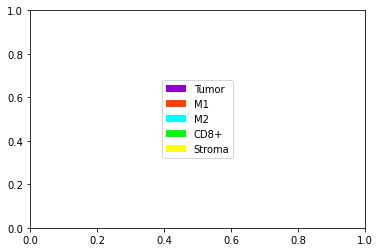

In [11]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

rgb = np.array([[148, 0, 211], [255, 69, 0], [0, 255, 255], [0, 255, 0], [255, 255, 0]])

legend_elements = [
    Patch(facecolor=rgb[0] / 255, label="Tumor"),
    Patch(facecolor=rgb[1] / 255, label="M1"),
    Patch(facecolor=rgb[2] / 255, label="M2"),
    Patch(facecolor=rgb[3] / 255, label="CD8+"),
    Patch(facecolor=rgb[4] / 255, label="Stroma"),
]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc="center")

plt.show()

In [12]:
import matplotlib.font_manager as fm
import networkx as nx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import color, filters, measure
from sklearn.neighbors import NearestNeighbors


def get_distances(cell_mask, r=30):
    # NN classifier
    neigh = NearestNeighbors(radius=r)

    # Get centroid of cellmask
    prop = measure.regionprops_table(cell_mask, properties=["label", "centroid"])
    X = np.column_stack((prop["centroid-0"], prop["centroid-1"]))

    # fit the k-NN classifier
    neigh.fit(X)
    distances, neighbors = neigh.radius_neighbors(
        X, return_distance=True, sort_results=True
    )
    graph = neigh.radius_neighbors_graph(X, mode="distance").toarray()
    return distances, neighbors, prop["label"], graph, X


def connectpoints(x, y, p1, p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1, x2], [y1, y2], "b-", color="red", alpha=1, lw=1, zorder=0)


def plot_nn(X, graph, node_colors, ax):
    G = nx.from_numpy_array(graph)
    pos = dict(zip(np.arange(len(X)), X[:, [1, 0]]))
    nx.draw(
        G,
        pos,
        node_size=5,
        node_color=node_colors,
        edge_color="gray",
        linewidths=2,
        ax=ax,
    )


def get_cell_color(df, labels, rgb):

    label2num = dict(zip(labels, [i for i in range(len(labels))]))
    num2color = dict([(i, rgb[i] / 255) for i in range(len(labels))])

    cell_max_marker = df.idxmax(axis=1)
    cell_max_marker = cell_max_marker.apply(label2num.get)

    # index_low = (df < 0).all(axis=1)
    # cell_max_marker[index_low] = 4
    cell_max_color = cell_max_marker.apply(num2color.get)

    return cell_max_marker.to_dict(), cell_max_color.values


def replace_with_dict(ar, dic):
    dic[0] = np.nan

    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks, ar)]


def myround(x, base=5):
    return base * round(x / base)

In [13]:
from collections import defaultdict

from numpy.lib.stride_tricks import as_strided


def get_nei_info(cell_labels, neighbors, node_class, distances):
    node_nei_info = defaultdict(dict)
    for idx, node in enumerate(cell_labels):
        neighbor = neighbors[idx][1:]
        nei_class = np.array([node_class[cell_labels[n]] for n in neighbor])
        nei_distance = distances[idx][
            1:
        ]  # First distance always correspond to 0 for item itself

        unique, counts = np.unique(nei_class, return_counts=True)
        for idx, c in enumerate(unique):
            node_nei_info[node][c] = {
                "count": counts[idx],
                "avg_distance": np.mean(nei_distance[np.where(nei_class == c)]),
            }
    return node_nei_info


def get_node_patch(X, node_class, n):
    nodes = node_class.keys()
    patches = X // n
    return dict(zip(nodes, patches))


def tile_array(a, b0, b1):
    r, c = a.shape  # number of rows/columns
    rs, cs = a.strides  # row/column strides
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0))  # view a as larger 4D array
    return x.reshape(r * b0, c * b1)  # create new 2D array


def patch_count(c, node_class, node_patch, n, shape):
    matching_node = [k for k, v in node_class.items() if v == c]
    patch_matrix = np.zeros(tuple(d // n for d in shape))
    for node in matching_node:
        i, j = node_patch[node]
        i = int(i)
        j = int(j)
        patch_matrix[i][j] += 1
    patch_matrix = patch_matrix
    return patch_matrix


def patch_count_neighbor(c1, c2, neighbor_class, node_class, node_patch, n, shape):
    patch_matrix = np.zeros(tuple(d // n for d in shape))
    for node, neighbors in neighbor_class.items():
        if neighbors.get(c2) and node_class[node] == c1:
            i, j = node_patch[node]
            i = int(i)
            j = int(j)
            patch_matrix[i][j] += neighbors.get(c2)["count"]
    patch_matrix = patch_matrix
    return patch_matrix


def count_neighbor(c1, c2, neighbor_class, node_class):
    count = 0
    for node, neighbors in neighbor_class.items():
        if neighbors.get(c2) and node_class[node] == c1:
            count += neighbors.get(c2)["count"]
    return count


def plot_count_patch(node_class, node_patch, n, shape, path=None):
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(patch_count(c, node_class, node_patch, n, shape))

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix), vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis("off")
        im = ax.imshow(patch_matrix[c], cmap="RdYlBu_r", norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label("Count")
    if path:
        fig.savefig(path, bbox_inches="tight")


def plot_interaction_patch(init_c, node_class, node_patch, n, shape, cmap, path=None):
    init_c = 0
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(
            patch_count_neighbor(init_c, c, neighbor_class, node_patch, n, shape)
        )

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix), vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis("off")
        im = ax.imshow(patch_matrix[c], cmap=cmap, norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label("Count")
    if path:
        fig.savefig(path, bbox_inches="tight")

In [14]:
h5_data = data_ROI / f"TMA.hdf5"

marker_subset = [
    "CD163",
    "CD206",
    "CD68",
    "HLADR",
    "Pankeratin",
    "E-cadherin",
    "CD8",
    "COL1",
    "SMA",
]

adata_macro = adata[:, marker_subset]
df = pd.DataFrame(adata_macro.X, columns=adata_macro.var_names)
df["Cell"] = adata_macro.obs["Cell"].to_list()
df["ROI"] = adata_macro.obs["ROI"].to_list()

In [15]:
n = 25
group = df.groupby("ROI")
labels = ["ECA+PanK", "M1", "M2", "CD8", "Col1+SMA"]
rgb = np.array([[148, 0, 211], [255, 69, 0], [0, 255, 255], [0, 255, 0], [255, 255, 0]])
mycmap = ListedColormap(rgb / 255)
fontprops = fm.FontProperties(size=34)
scores = defaultdict(list)
scores_count = defaultdict(list)
scores_all = defaultdict(list)
density = defaultdict(list)
density_total = defaultdict(list)

for name, df_subset in group:
    imgs, _ = get_imgs(h5_data, name)
    print(imgs[0].shape)
    # Get mask
    cell_mask = masks[name]
    min_shape = min(cell_mask.shape[0], cell_mask.shape[1])
    min_shape = myround(min_shape, base=n)
    cell_mask = cell_mask[:min_shape, :min_shape]
    avg_img = np.array(np.mean(imgs, axis=(0)))[:min_shape, :min_shape]

    # Get group intensity
    df_subset["M2"] = df_subset[["CD163", "CD206"]].max(axis=1)
    df_subset.loc[df_subset.CD68 < 10, "CD163_CD206"] = 0
    df_subset["M1"] = np.where(df_subset["CD68"] < 10, 0, df_subset["HLADR"])
    df_subset["ECA+PanK"] = df_subset[["Pankeratin", "E-cadherin"]].max(axis=1)
    df_subset["Col1+SMA"] = df_subset[["COL1", "SMA"]].max(axis=1)
    df_subset.set_index("Cell", inplace=True)
    df_subset = df_subset[labels]

    # Get cell neighbors analysis
    distances, neighbors, cell_labels, graph, X = get_distances(cell_mask)
    node_class, node_colors = get_cell_color(df_subset, labels, rgb)
    node_class, _ = get_cell_color(df_subset, labels, rgb)
    neighbor_class = get_nei_info(cell_labels, neighbors, node_class, distances)
    node_patch = get_node_patch(X, node_class, n)

#     # Plot proximity map
#     fig, ax = plt.subplots(figsize=(15, 15))
#     ax.axis("off")
#     plot_nn(X, graph, node_colors, ax)
#     ax.invert_yaxis()
#     ax.set_facecolor("black")
#     fig.patch.set_facecolor("black")
#     fig.savefig(
#         data_figure / "border" / f"new_cell_graph_{name}.png", bbox_inches="tight"
#     )

#     # Plot cell mask
    img = replace_with_dict(cell_mask, node_class)
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(img, cmap=mycmap, interpolation="None", vmin=0, vmax=5)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_facecolor("black")
#     fig.savefig(
#         data_figure / "border" / f"new_cell_mask_{name}.png", bbox_inches="tight"
#     )
    
    unique, counts = np.unique(img[~np.isnan(img)], return_counts=True)
    density['Tumor'].append(round(counts[0]/np.sum(~np.isnan(img)),4))
    density['Stroma'].append(round(counts[4]/np.sum(~np.isnan(img)),4))
    density['CD8+'].append(round(counts[3]/np.sum(~np.isnan(img)),4))
    density['M1'].append(round(counts[1]/np.sum(~np.isnan(img)),4))
    density['M2'].append(round(counts[2]/np.sum(~np.isnan(img)),4))
    
    density_total['Tumor'].append(counts[0])
    density_total['Stroma'].append(counts[4])
    density_total['CD8+'].append(counts[3])
    density_total['M1'].append(counts[1])
    density_total['M2'].append(counts[2])

    # Get tumor and Stroma island
    tumor = patch_count(0, node_class, node_patch, n, avg_img.shape)
    m1 = patch_count(1, node_class, node_patch, n, avg_img.shape)
    m2 = patch_count(2, node_class, node_patch, n, avg_img.shape)
    ip = patch_count(3, node_class, node_patch, n, avg_img.shape)
    stroma = patch_count(4, node_class, node_patch, n, avg_img.shape)

    total = [patch_count(i, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    total = np.sum(total, axis=(0))
    P_tumor = np.divide(tumor, total, out=np.zeros_like(total), where=total != 0)
    P_m1 = np.divide(m1, total, out=np.zeros_like(total), where=total != 0)
    P_m2 = np.divide(m2, total, out=np.zeros_like(total), where=total != 0)
    P_ip = np.divide(ip, total, out=np.zeros_like(total), where=total != 0)
    P_stroma = np.divide(stroma, total, out=np.zeros_like(total), where=total != 0)

#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(P_tumor, vmin=0, vmax=1, cmap="bwr")
#     ax.tick_params(
#         axis="both", which="both", length=0, labelbottom=False, labelleft=False
#     )
#     fig.savefig(data_figure / "border" / f"new_tumor_{name}.png", bbox_inches="tight")

    # M1
    m1_t_int = patch_count_neighbor(
        1, 0, neighbor_class, node_class, node_patch, n, avg_img.shape
    )
    m1_int_total = [
        patch_count_neighbor(
            1, i, neighbor_class, node_class, node_patch, n, avg_img.shape
        )
        for i in range(5)
    ]
    m1_int_total = np.sum(m1_int_total, axis=(0))
    P_m1_t = np.divide(
        m1_t_int, m1_int_total, out=np.zeros_like(m1_int_total), where=m1_int_total != 0
    )

    # M2
    m2_t_int = patch_count_neighbor(
        2, 0, neighbor_class, node_class, node_patch, n, avg_img.shape
    )
    m2_int_total = [
        patch_count_neighbor(
            2, i, neighbor_class, node_class, node_patch, n, avg_img.shape
        )
        for i in range(5)
    ]
    m2_int_total = np.sum(m2_int_total, axis=(0))
    P_m2_t = np.divide(
        m2_t_int, m2_int_total, out=np.zeros_like(m2_int_total), where=m2_int_total != 0
    )

    # IP
    ip_t_int = patch_count_neighbor(
        3, 0, neighbor_class, node_class, node_patch, n, avg_img.shape
    )
    ip_int_total = [
        patch_count_neighbor(
            3, i, neighbor_class, node_class, node_patch, n, avg_img.shape
        )
        for i in range(5)
    ]
    ip_int_total = np.sum(ip_int_total, axis=(0))
    P_ip_t = np.divide(
        ip_t_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total != 0
    )

    # --- Plot
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(np.multiply(P_tumor, P_ip_t), vmin=0, vmax=1, cmap="Greens")
#     ax.tick_params(
#         axis="both", which="both", length=0, labelbottom=False, labelleft=False
#     )
#     fig.savefig(data_figure / "border" / f"new_ip_{name}.png", bbox_inches="tight")

#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(np.multiply(P_tumor,P_m2_t), vmin=0, vmax=1, cmap="Blues")
#     ax.tick_params(
#         axis="both", which="both", length=0, labelbottom=False, labelleft=False
#     )
#     fig.savefig(data_figure / "border" / f"new_m2_{name}.png", bbox_inches="tight")

#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(np.multiply(P_tumor,P_m1_t), vmin=0, vmax=1, cmap="Oranges")
#     ax.tick_params(
#         axis="both", which="both", length=0, labelbottom=False, labelleft=False
#     )
#     fig.savefig(data_figure / "border" / f"new_m1_{name}.png", bbox_inches="tight")

    scores_count['Tumor-Tumor'].append(count_neighbor(0, 0, neighbor_class, node_class))
    scores_count['Tumor-M1'].append(count_neighbor(0, 1, neighbor_class, node_class))
    scores_count['Tumor-M2'].append(count_neighbor(0, 2, neighbor_class, node_class))
    scores_count['Tumor-CD8+'].append(count_neighbor(0, 3, neighbor_class, node_class))
    scores_count['Tumor-Stroma'].append(count_neighbor(0, 4, neighbor_class, node_class))
    scores_count['M1-M1'].append(count_neighbor(1, 1, neighbor_class, node_class))
    scores_count['M1-M2'].append(count_neighbor(1, 2, neighbor_class, node_class))
    scores_count['M1-CD8+'].append(count_neighbor(1, 3, neighbor_class, node_class))
    scores_count['M1-Stroma'].append(count_neighbor(1, 4, neighbor_class, node_class))
    scores_count['M2-M2'].append(count_neighbor(2, 2, neighbor_class, node_class))
    scores_count['M2-CD8+'].append(count_neighbor(2, 3, neighbor_class, node_class))
    scores_count['M2-Stroma'].append(count_neighbor(2, 4, neighbor_class, node_class))
    scores_count['CD8+-Stroma'].append(count_neighbor(3, 4, neighbor_class, node_class))
    scores_count['CD8+-CD8+'].append(count_neighbor(3, 3, neighbor_class, node_class))
    scores_count['Stroma-Stroma'].append(count_neighbor(4, 4, neighbor_class, node_class))
    
    
    m1_s = patch_count_neighbor(1, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m1_m2 = patch_count_neighbor(1, 2, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m1_cd8 = patch_count_neighbor(1, 3, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m1_total = [patch_count_neighbor(1, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    m1_total = np.sum(m1_total, axis=(0))
    P_m1_s = np.divide(m1_s, m1_total, out=np.zeros_like(m1_total), where=m1_total!=0)
    P_m1_m2 = np.divide(m1_m2, m1_total, out=np.zeros_like(m1_total), where=m1_total!=0)
    P_m1_cd8 = np.divide(m1_m2, m1_total, out=np.zeros_like(m1_total), where=m1_total!=0)
    
    m2_s = patch_count_neighbor(2, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m2_m1 = patch_count_neighbor(2, 1, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m2_cd8 = patch_count_neighbor(2, 3, neighbor_class, node_class, node_patch, n, avg_img.shape)
    m2_total = [patch_count_neighbor(1, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    m2_total = np.sum(m2_total, axis=(0))
    P_m2_s = np.divide(m2_s, m1_total, out=np.zeros_like(m2_total), where=m2_total!=0)
    P_m2_m1 = np.divide(m2_m1, m1_total, out=np.zeros_like(m2_total), where=m2_total!=0)
    P_m2_cd8 = np.divide(m2_cd8, m1_total, out=np.zeros_like(m2_total), where=m2_total!=0)
    
    ip_s_int = patch_count_neighbor(3, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_m1_int = patch_count_neighbor(3, 1, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_m2_int = patch_count_neighbor(3, 2, neighbor_class, node_class, node_patch, n, avg_img.shape)
    ip_int_total = [patch_count_neighbor(2, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    ip_int_total = np.sum(ip_int_total, axis=(0))
    P_ip_s = np.divide(ip_s_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)
    P_ip_m1 = np.divide(ip_m1_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)
    P_ip_m2 = np.divide(ip_m2_int, ip_int_total, out=np.zeros_like(ip_int_total), where=ip_int_total!=0)
    
    scores["Tumor"].append(round(np.mean(P_tumor), 4))
    scores["Stroma"].append(round(np.mean(P_stroma), 4))
    scores["CD8+"].append(round(np.mean(P_ip), 4))
    scores["M1"].append(round(np.mean(P_m1), 4))
    scores["M2"].append(round(np.mean(P_m2), 4))
    scores['M1-T'].append(round(np.mean(P_m1_t),4))
    scores['M2-T'].append(round(np.mean(P_m2_t),4))
    scores['CD8-T'].append(round(np.mean(P_ip_t),4))
    scores['CD8-S'].append(round(np.mean(P_ip_s),4))
    scores['CD8-M1'].append(round(np.mean(P_ip_m1),4))
    scores['CD8-M2'].append(round(np.mean(P_ip_m2),4))
    scores['M1-S'].append(round(np.mean(P_m1_s),4))
    scores['M1-M2'].append(round(np.mean(P_m1_m2),4))
    scores['M1-CD8'].append(round(np.mean(P_m1_cd8),4))
    scores['M2-S'].append(round(np.mean(P_m2_s),4))
    scores['M2-M1'].append(round(np.mean(P_m2_m1),4))
    scores['M2-CD8'].append(round(np.mean(P_m2_cd8),4))
    
    t_t_int = patch_count_neighbor(0, 0, neighbor_class, node_class, node_patch, n, avg_img.shape)
    t_int_total = [patch_count_neighbor(0, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    t_int_total = np.sum(t_int_total, axis=(0))
    P_t_t = np.divide(t_t_int, t_int_total, out=np.zeros_like(t_int_total), where=t_int_total!=0)
    
    s_s_int = patch_count_neighbor(4, 4, neighbor_class, node_class, node_patch, n, avg_img.shape)
    s_int_total = [patch_count_neighbor(4, i, neighbor_class, node_class, node_patch, n, avg_img.shape) for i in range(5)]
    s_int_total = np.sum(s_int_total, axis=(0))
    P_s_s = np.divide(s_s_int, s_int_total, out=np.zeros_like(s_int_total), where=s_int_total!=0)
    
    scores_all["T-T"].append(P_t_t),
    scores_all["S-S"].append(P_s_s)
    scores_all["CD8+"].append(P_ip)
    scores_all['M1-T'].append(P_m1_t)
    scores_all['M2-T'].append(P_m2_t)
    scores_all['CD8-T'].append(P_ip_t)
    scores_all['CD8-S'].append(P_ip_s)
    scores_all['CD8-M1'].append(P_ip_m1)
    scores_all['CD8-M2'].append(P_ip_m2)
    scores_all['M1-S'].append(P_m1_s)
    scores_all['M1-M2'].append(P_m1_m2)
    scores_all['M1-CD8'].append(P_m1_cd8)
    scores_all['M2-S'].append(P_m2_s)
    scores_all['M2-M1'].append(P_m2_m1)
    scores_all['M2-CD8'].append(P_m2_cd8)

(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)
(1500, 1500)


In [33]:
datasets

['B7', 'C3', 'D1', 'D2', 'D5', 'D9', 'F7', 'G3', 'H1', 'H2', 'H5', 'H9']

In [34]:
datasets = list(group.groups.keys())

In [35]:
df = pd.DataFrame(scores, index=datasets)
df

,Tumor,Stroma,CD8+,M1,M2,M1-T,M2-T,CD8-T,CD8-S,CD8-M1,CD8-M2,M1-S,M1-M2,M1-CD8,M2-S,M2-M1,M2-CD8
B7,0.3616,0.1434,0.1399,0.0742,0.0370,0.0649,0.0321,0.1691,0.0296,0.0269,0.0268,0.0401,0.0156,0.0156,0.0121,0.0127,0.0215
C3,0.3777,0.1394,0.2022,0.0537,0.0729,0.0930,0.0610,0.2184,0.0696,0.0284,0.0690,0.0233,0.0239,0.0239,0.0178,0.0167,0.0495
D1,0.4011,0.1521,0.1695,0.1041,0.0430,0.1041,0.0638,0.1285,0.0441,0.0520,0.0352,0.0458,0.0241,0.0241,0.0143,0.0249,0.0361
D2,0.2887,0.3004,0.1744,0.0758,0.0218,0.0745,0.0281,0.1671,0.0284,0.0196,0.0146,0.0683,0.0081,0.0081,0.0077,0.0066,0.0150
D5,0.5880,0.0948,0.0755,0.0860,0.0140,0.1907,0.0391,0.2539,0.0027,0.0027,0.0031,0.0309,0.0037,0.0037,0.0020,0.0026,0.0022
D9,0.3315,0.3653,0.1269,0.0764,0.0238,0.1317,0.0517,0.1944,0.0403,0.0222,0.0127,0.1021,0.0096,0.0096,0.0146,0.0069,0.0113
F7,0.4793,0.1306,0.1623,0.0603,0.0147,0.0460,0.0066,0.1724,0.0199,0.0124,0.0075,0.0342,0.0063,0.0063,0.0078,0.0049,0.0064
G3,0.2920,0.2362,0.1464,0.0767,0.0404,0.0945,0.0293,0.1742,0.0813,0.0250,0.0338,0.0364,0.0119,0.0119,0.0163,0.0115,0.0199
H1,0.5572,0.0436,0.0355,0.0497,0.0126,0.1473,0.0470,0.1318,0.0053,0.0084,0.0031,0.0149,0.0046,0.0046,0.0033,0.0036,0.0025
H2,0.2320,0.1608,0.1040,0.1790,0.0740,0.1373,0.0442,0.1027,0.0374,0.0340,0.0247,0.0374,0.0337,0.0337,0.0177,0.0323,0.0157


Text(0.5, 0, 'Cell Type')

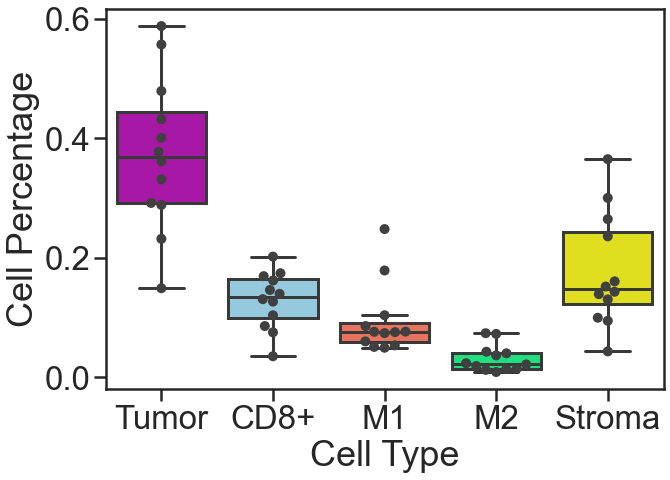

In [43]:
sns.set_style("ticks")
sns.set_context("poster", font_scale=1.5)

my_pal = {'Tumor': 'm', 'CD8+':'skyblue', 'M1':'tomato' , 'M2':'springgreen', 'Stroma':'yellow'}


fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.boxplot(data=df, palette=my_pal, order=['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'])
ax = sns.swarmplot(data=df, color="0.25", size=10, order=['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'])
ax.set_ylabel('Cell Percentage')
ax.set_xlabel('Cell Type')

In [26]:
from statannotations.Annotator import Annotator


In [31]:
df = pd.DataFrame(density_total, index=datasets)
# df = df/2.5
df_subset = df.iloc[:6,:5]
df_subset['Immune Status'] = ['Suppressed', 'Inflamed', 'Cold', 'Cold', 'Inflamed', 'Suppressed', 'Suppressed', 'Inflamed', 'Suppressed', 'Cold', 'Inflamed', 'Cold'][:6]
df_subset = pd.melt(df_subset, id_vars=['Immune Status'], var_name='Cell Type', value_name='Density')

Text(0, 0.5, 'Density (Cells/mm²)')

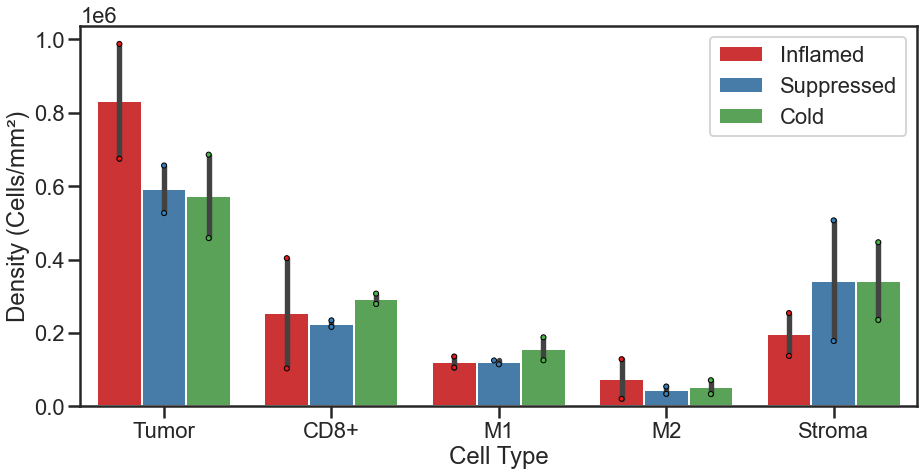

In [32]:
hue_plot_params = {
    'data':      df_subset,
    'x':         'Cell Type',
    'y':         'Density',
    "order":     ['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'],
    "hue":       "Immune Status",
    "hue_order": ['Inflamed', 'Suppressed', 'Cold'],
    "palette":   "Set1"
}

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(**hue_plot_params)
ax = sns.swarmplot(**hue_plot_params, dodge=True, edgecolor='k', linewidth=1.0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:])
ax.set_ylabel("Density (Cells/mm\u00b2)")

# # Anotation paris
# pairs = [[(cell_type, 'Inflamed'), (cell_type, 'Cold')] for cell_type in df_subset['Cell Type'].unique()] 
# pairs += [[(cell_type, 'Inflamed'), (cell_type, 'Suppressed')] for cell_type in df_subset['Cell Type'].unique()] 
# pairs +=  [[(cell_type, 'Suppressed'), (cell_type, 'Cold')] for cell_type in df_subset['Cell Type'].unique()]

# # Add annotations
# annotator = Annotator(ax, pairs, **hue_plot_params)
# annotator.configure(test='Mann-Whitney', verbose=True)
# _, results = annotator.apply_and_annotate()


In [44]:
df = pd.DataFrame(scores_count, index=datasets)

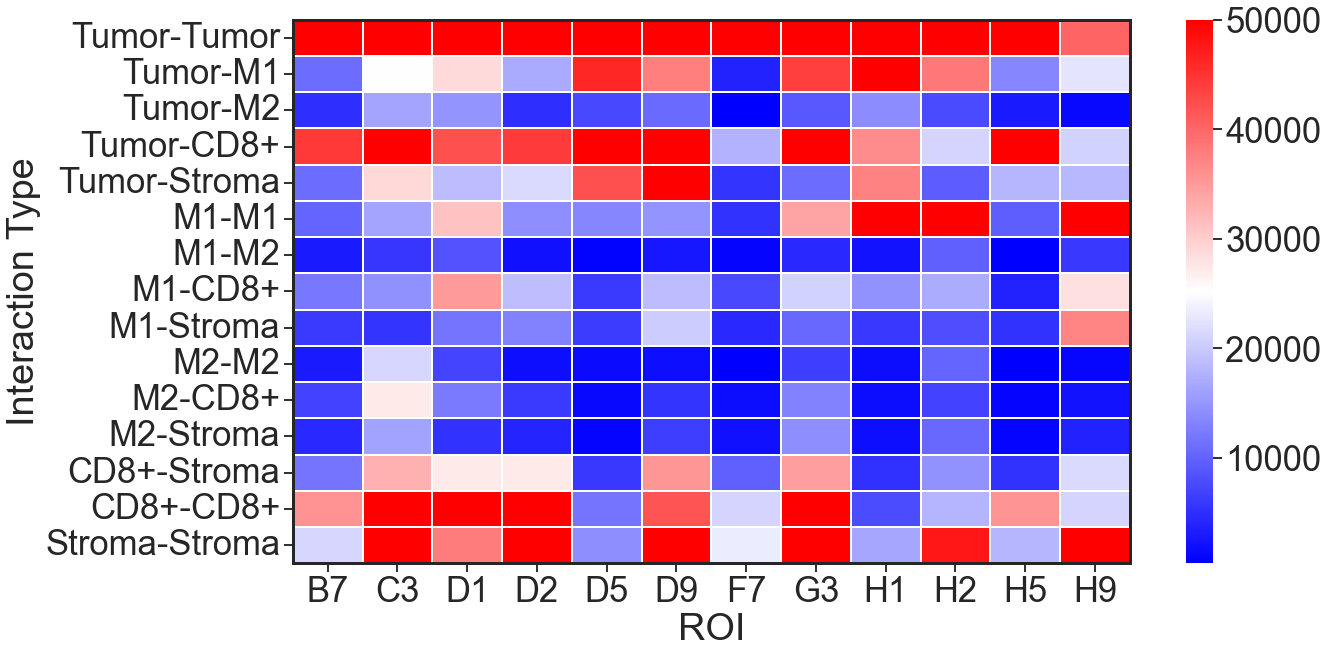

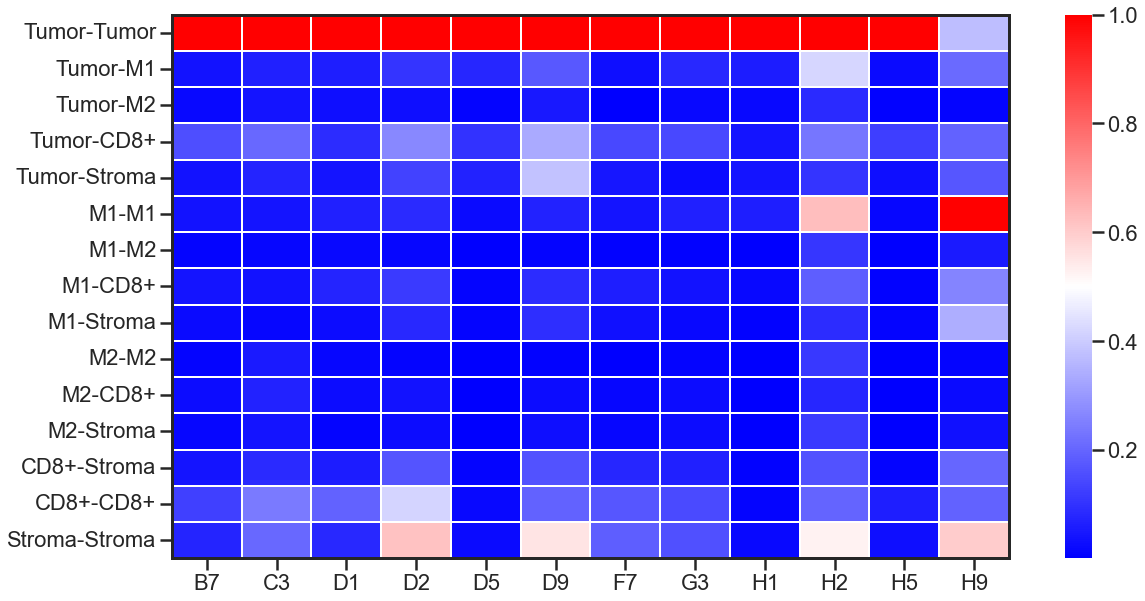

In [47]:
# Clustermap
from matplotlib.colors import LogNorm

my_cmap = 'bwr'
scale_name = "Score"

sns.set_style("ticks")
sns.set_context("talk", font_scale=2.1)

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(
    df.T,
    cbar_kws={"fraction": 0.2},
    cmap=my_cmap,
    linewidth=0.1,
    vmax=50000,
    yticklabels=True
#     norm = LogNorm()
)
ax.set_ylabel('Interaction Type')
ax.set_xlabel('ROI')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Scaled
# scaler = MinMaxScaler() 
# scaled_values = scaler.fit_transform(df.T)
# df_scaled = pd.DataFrame(scaled_values.T, index=df.index, columns=df.columns)
df_scaled = df.div(df.max(axis=1), axis=0)

# Clustermap
from matplotlib.colors import LogNorm

my_cmap = 'bwr'
scale_name = "Score"

sns.set_style("ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(
    df_scaled.T,
    cbar_kws={"fraction": 0.2},
    cmap=my_cmap,
    linewidth=0.1,
#     norm = LogNorm()
)


for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    


In [25]:
df_scaled

,Tumor-Tumor,Tumor-M1,Tumor-M2,Tumor-CD8+,Tumor-Stroma,M1-M1,M1-M2,M1-CD8+,M1-Stroma,M2-M2,M2-CD8+,M2-Stroma,CD8+-Stroma,CD8+-CD8+,Stroma-Stroma
B7,1.000000,0.038411,0.017542,0.156510,0.038598,0.035923,0.010405,0.042708,0.021426,0.010743,0.024235,0.015469,0.041329,0.126026,0.074672
C3,1.000000,0.063169,0.040867,0.205417,0.072638,0.040955,0.014411,0.036403,0.013828,0.053496,0.068266,0.040500,0.082638,0.242060,0.206096
D1,1.000000,0.061264,0.031297,0.089454,0.039892,0.066240,0.017670,0.074237,0.025010,0.015032,0.026019,0.011386,0.057832,0.193618,0.080574
D2,1.000000,0.103280,0.030144,0.269289,0.131153,0.086237,0.012580,0.114639,0.078909,0.011062,0.036349,0.024316,0.165262,0.417685,0.620225
D5,1.000000,0.076634,0.012163,0.101961,0.069747,0.022288,0.001128,0.010147,0.010299,0.002369,0.002114,0.001403,0.009582,0.019297,0.023554
D9,1.000000,0.173540,0.049128,0.334718,0.382753,0.068604,0.012269,0.086629,0.093304,0.008318,0.025051,0.030244,0.163408,0.192369,0.551709
F7,1.000000,0.030648,0.003625,0.141321,0.044147,0.042415,0.007163,0.059940,0.034907,0.003754,0.012930,0.016050,0.078268,0.168600,0.186695
G3,1.000000,0.081485,0.016552,0.144798,0.020299,0.063137,0.008030,0.038578,0.019528,0.012131,0.024156,0.026408,0.064029,0.145355,0.158599
H1,1.000000,0.057603,0.016292,0.041885,0.043047,0.062126,0.002508,0.016782,0.006711,0.001958,0.001770,0.002190,0.005898,0.009115,0.019048
H2,1.000000,0.421914,0.084138,0.231694,0.103473,0.628893,0.106367,0.187501,0.088122,0.111539,0.076017,0.116689,0.161289,0.196888,0.526685


# Pixels

In [ ]:
from skimage.measure import block_reduce
from scipy.ndimage import distance_transform_edt
from numpy.lib.stride_tricks import as_strided
from matplotlib.colors import ListedColormap
from skimage import color, measure, filters

def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(r*b0, c*b1)                      # create new 2D array

def mean_block(img, block_size):
    img_reduced = tile_array(block_reduce(img, block_size=block_size, func=np.mean), block_size[0], block_size[0])
#     img_reduced = (img_reduced - img_reduced.min())/(img_reduced.max() - img_reduced.min())
    img_reduced /= 255
    return img_reduced

def myround(x, base=5):
    return base * round(x/base)

def plot_mean(imgs_list, n, labels):
    patch_matrix = []
    for c in range(4):
        patch_matrix.append(mean_block(imgs_list[c], (n,n)))

    fig, axs = plt.subplots(2,2, figsize = (12,10))
    ax = axs.flatten()
    norm = plt.Normalize(vmin=np.min(patch_matrix),
                         vmax=np.max(patch_matrix))
    for c, ax in enumerate(ax):
        ax.axis('off')
        im = ax.imshow(patch_matrix[c], cmap = 'RdYlBu_r', norm=norm)
        ax.title.set_text(labels[c])
    fig.subplots_adjust(hspace=0.1, wspace=0.01)
    cbar = fig.colorbar(im, ax=axs, shrink=0.5)
    cbar.set_label('Intensity')
    plt.show()
    return patch_matrix

def plot_combined(imgs_list, n, int_min=0.05):
    patch_matrix = []
    for c in range(5):
        patch_matrix.append(mean_block(imgs_list[c], (n,n)))
    patch_matrix = np.array(patch_matrix)
    patch_max = np.argmax(patch_matrix, axis=(0))
    patch_max = np.where(np.all(patch_matrix < int_min, axis=0), np.nan, patch_max)
    
    rgb = np.array([[148, 0, 211], [255, 69, 0], [0, 0, 255], [0, 255, 0], [255, 255, 0]])/255
    cmap = ListedColormap(rgb)
                   
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(patch_max, cmap=cmap, vmin=0, vmax=4, interpolation='none')
    ax.set_facecolor('black')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return patch_max

In [ ]:
def get_proportion(patch_max, n):
    img_size = patch_max.shape[0] * patch_max.shape[1]
    P = np.count_nonzero(patch_max == n) / img_size
    return P

def get_label_img(patch_max, n):
    labels = measure.label(patch_max == n, background=0, connectivity=2)
    return labels

def get_contour(labeled_img, n = 2):
    labels = np.unique(labeled_img)[1:]
    contours = []
    labels_filtered = []
    
    for label in labels:
        mask_label = (labeled_img == label)
        labels_filtered.append(label)
        mask_label = ~mask_label
        distances = distance_transform_edt(mask_label)
        contour = np.where(np.logical_and(distances>0, distances<n), 1, 0)
        row, col = np.where(contour > 0)
        contours.append(np.array(list(zip(row, col))))
        
    return labels_filtered, contours

def get_neighbor_env(img_labeled, patch_max, n_size=2, show=True):
    props = measure.regionprops(img_labeled)
    areas = []
    labels = []
    counts = []
    bboxs = []
    for prop in props:
        if prop['area'] > 1:
            bbox = np.asarray(prop['bbox'])
            bbox += np.array([-n_size, -n_size , n_size , n_size])
            bbox = np.clip(bbox, a_min = 0, a_max = None)
            row_min, col_min, row_max, col_max = bbox

            patch_max_roi = patch_max[row_min: row_max, col_min:col_max]
            size = patch_max_roi.size
            patch_max_roi = patch_max_roi[~np.isnan(patch_max_roi)].astype(int)
            count = Counter(patch_max_roi[~np.isnan(patch_max_roi)])   
            count = {k:v/size for k,v in count.items()}
            counts.append(count)
            areas.append(prop['area'])
            labels.append(prop['label'])
            bboxs.append(bbox)


    if show:
        rgb = np.array([[148, 0, 211], [255, 69, 0], [0, 255, 255], [0, 255, 0], [255, 255, 0]])/255
        cmap = ListedColormap(rgb)
        fig, ax = plt.subplots( figsize=(10,10))
        ax.imshow(patch_max, cmap=cmap, vmin=0, vmax=3, interpolation='none')
        ax.set_facecolor('black')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for bbox in bboxs:
            row_min, col_min, row_max, col_max = bbox
            ax.add_patch(Rectangle((col_min-1, row_min-1), col_max-col_min+1, row_max-row_min+1, fill=None, alpha=1, edgecolor='b', lw=2))
    return counts, areas, labels, bboxs

def get_contour_env(img_labeled, contours, patch_max, n=1,show=True):
    if show:
        mask = np.zeros(img_labeled.shape)
        for contour in contours:
            mask[contour[:, 0], contour[:, 1]] = 1
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(mask, cmap='gray', interpolation=None)
        ax.imshow(np.where(img_labeled == 0, np.nan, n), cmap='Set1', vmin=0, vmax=9, interpolation=None)
        ax.axis('off')
    
    counts = []
    for contour in contours:
        env = patch_max[contour[:,0], contour[:,1]]
        size = len(env)
        count = Counter(env[~np.isnan(env)].astype(int))   
        count = {k:v/size for k,v in count.items()}
        counts.append(count)
        
    return counts

def get_interaction(counts):
    tumor_int = []
    stroma_int = []
    m1_int = []
    m2_int = []
    ip_int = []

    for count in counts:
        tumor_int.append(count.get(0, 0.))
        m1_int.append(count.get(1, 0.))
        m2_int.append(count.get(2, 0.))
        ip_int.append(count.get(3, 0.))
        stroma_int.append(count.get(4, 0.))

    tumor_int = np.mean(tumor_int)
    stroma_int = np.mean(stroma_int)
    ip_int = np.mean(ip_int)
    m1_int = np.mean(m1_int)
    m2_int = np.mean(m2_int)

    return tumor_int, stroma_int, ip_int, m1_int, m2_int



In [ ]:
from skimage.restoration import denoise_bilateral
from collections import Counter, defaultdict

n = 10
scores_pixels = defaultdict(list)
labels = ["ECA+PanK", "M1", "M2", "CD8", "Col1+SMA"]
marker_list = [["Pankeratin", "E-cadherin"],["HLADR","CD68"], ["CD163", "CD206", "CD68"], ['CD8'], ['COL1', 'SMA']]

h5_data = data_ROI / f"TMA.hdf5"
df = pd.read_csv(data_ROI / f"info.csv")

datasets = df.ROI.unique()

for dataset in datasets:

    # Read image and cell_mask
    imgs, markers = get_imgs(h5_data, dataset)
    marker2img = dict(zip(markers, imgs))
    min_shape = min(imgs[0].shape[0], imgs[0].shape[1])
    min_shape = myround(min_shape, base=n)
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            p2, p98 = np.percentile(img, (2, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[:min_shape, :min_shape])
        if 'CD68' in markers:
            img = np.max(temp[:-1], axis=(0))
            img = np.where(temp[-1] > 5, img, 0)
            imgs_list.append(img)
        else:
            imgs_list.append(np.array(np.max(temp, axis=(0))))

    # Grayscale backgroun image
    data = np.stack(imgs_list, axis=2)
    
    # Pixel
    patch_matrix = plot_mean(imgs_list, n, labels)
    patch_max = plot_combined(imgs_list, n)
    
    scores_pixels['Tumor'].append(get_proportion(patch_max, 0))
    M1_prop = get_proportion(patch_max, 1)
    scores_pixels['M1'].append(M1_prop)
    M2_prop = get_proportion(patch_max, 2)
    scores_pixels['M2'].append(M2_prop)
    IP_prop = get_proportion(patch_max, 3)
    scores_pixels['CD8+'].append(IP_prop)
    scores_pixels['Stroma'].append(get_proportion(patch_max, 4))
    
    M1_labels = get_label_img(patch_max, 1)
    M2_labels = get_label_img(patch_max, 2)
    IP_labels = get_label_img(patch_max, 3)
    
    # Immune positif
    _, contours = get_contour(IP_labels, n=2)
    counts = get_contour_env(IP_labels, contours, patch_max, n=2, show=False)
    tumor_int, stroma_int, ip_int, m1_int, m2_int = get_interaction(counts)
    
    scores_pixels['CD8-T'].append(tumor_int*IP_prop)
    scores_pixels['CD8-S'].append(stroma_int*IP_prop)
    scores_pixels['CD8-M1'].append(m1_int*IP_prop)
    scores_pixels['CD8-M2'].append(m2_int*IP_prop)
    
    # # Immune negatif
    _, contours = get_contour(M1_labels, n=2)
    counts = get_contour_env(M1_labels, contours, patch_max, n=2, show=False)
    tumor_int, stroma_int, ip_int, m1_int, m2_int = get_interaction(counts)

    scores_pixels['M1-T'].append(tumor_int*M1_prop)
    scores_pixels['M1-S'].append(stroma_int*M1_prop)
    scores_pixels['M1-M2'].append(m2_int*M1_prop)
    scores_pixels['M1-CD8'].append(ip_int*M1_prop)
    
    _, contours = get_contour(M2_labels, n=2)
    counts = get_contour_env(M2_labels, contours, patch_max, n=2, show=False)
    tumor_int, stroma_int, ip_int, m1_int, m2_int = get_interaction(counts)
    
    scores_pixels['M2-T'].append(tumor_int*M2_prop)
    scores_pixels['M2-S'].append(stroma_int*M2_prop)
    scores_pixels['M2-M1'].append(m1_int*M2_prop)
    scores_pixels['M2-CD8'].append(ip_int*M2_prop)


In [ ]:
df = pd.DataFrame(scores_pixels, index=datasets)
df.index = [index[-2:] for index in df.index]

df

In [ ]:
# Clustermap
from matplotlib.colors import LogNorm

my_cmap = 'bwr'
scale_name = "Score"

sns.set_style("ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(
    df.iloc[:,:5].T,
    cbar_kws={"fraction": 0.2},
    cmap=my_cmap,
    linewidth=0.1,
    # norm = LogNorm()
    vmax=0.3
)

ax.set_yticklabels(ax.get_yticklabels(), va='center')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

In [ ]:
sns.set_style("ticks")
sns.set_context("poster")

my_pal = {'Tumor': 'm', 'CD8+':'skyblue', 'M1':'tomato' , 'M2':'springgreen', 'Stroma':'yellow'}


fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.boxplot(data=df.iloc[:,:5], palette=my_pal, order=['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'])
ax = sns.swarmplot(data=df.iloc[:,:5], color="0.25", size=10, order=['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'])

# Scatter

In [32]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [33]:
df_cell = pd.DataFrame(scores, index=datasets)
df_cell.index = [index[-2:] for index in df_cell.index]

In [34]:
values = scaler.fit_transform(df_cell.values)

df_cell = pd.DataFrame(values, columns=df_cell.columns, index=df_cell.index)*10

In [35]:
df_sorted = df_cell.sort_values(by='CD8-T')

In [36]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
colors = LE.fit_transform(pd.qcut(df_sorted['CD8-T'], q=[0., 0.25, 0.75, 1.0]))

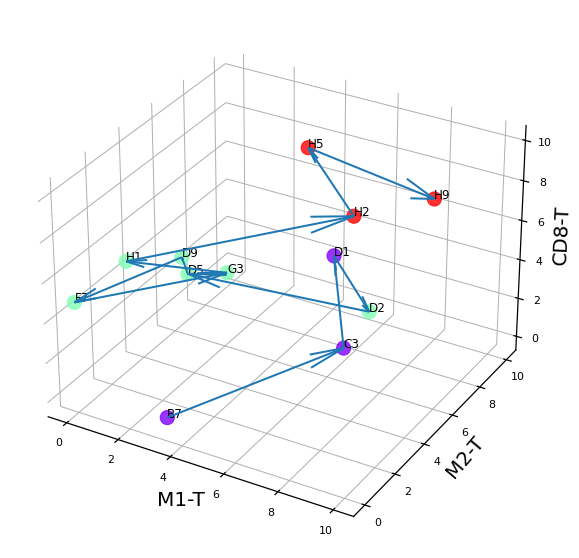

In [37]:
from sklearn.preprocessing import normalize 

sns.set_context("notebook")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

z = df_sorted['CD8-T']
x = df_sorted['M1-T']
y = df_sorted['M2-T']

ax.set_xlabel('M1-T', fontsize=20)
ax.set_ylabel('M2-T', fontsize=20, rotation=50)
ax.set_zlabel('CD8-T', fontsize=20, rotation=88)
ax.scatter(x, y, z, s=200, c=colors, cmap='rainbow', alpha=0.8)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for txt, xs, ys, zs in zip(df_cell.index.tolist(), x, y, z):
    ax.text(xs, ys, zs, txt)
    
points = np.vstack([x,y,z]).T
vels = np.zeros(points.shape)
for i in range(len(vels)-1):
    vels[i] = points[i+1] - points[i]
    # vels[i] = vels[i]/np.linalg.norm(vels[i])/10
ax.quiver(points[:,0], points[:,1], points[:,2], vels[:,0], vels[:,1], vels[:,2], linewidths=2, arrow_length_ratio=0.2)


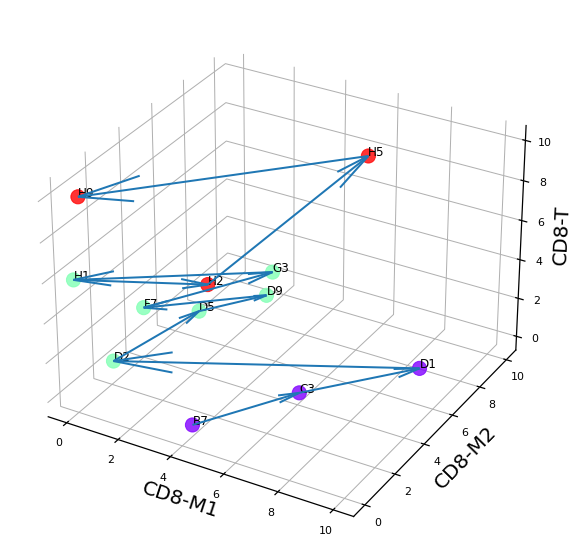

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x = df_sorted['CD8-M1']
y = df_sorted['CD8-M2']
z = df_sorted['CD8-T']

ax.set_xlabel('CD8-M1', fontsize=20)
ax.set_ylabel('CD8-M2', fontsize=20, rotation=50)
ax.set_zlabel('CD8-T', fontsize=20, rotation=88)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.scatter(x, y, z, s=200, c=colors, cmap='rainbow', alpha=0.8)

for txt, xs, ys, zs in zip(df_cell.index.tolist(), x, y, z):
    ax.text(xs, ys, zs, txt)
    
points = np.vstack([x,y,z]).T
vels = np.zeros(points.shape)
for i in range(len(vels)-1):
    vels[i] = points[i+1] - points[i]
    # vels[i] = vels[i]/np.linalg.norm(vels[i])/50
ax.quiver(points[:,0], points[:,1], points[:,2], vels[:,0], vels[:,1], vels[:,2], linewidths=2, arrow_length_ratio=0.2)


In [39]:
df_subset = df_sorted.iloc[:,5:]
df_subset['CD8-T'] = df_subset['CD8-T']*5

C:\Users\thu71\AppData\Local\Temp/ipykernel_90052/188691077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['CD8-T'] = df_subset['CD8-T']*5


In [40]:
import matplotlib 
cmap = matplotlib.cm.get_cmap('rainbow')
colors_bar = cmap(colors/np.max(colors))

In [41]:
hex_color = []
for c in colors_bar:
    hex_color.append("#{0:02X}{1:02X}{2:02X}".format(int(c[0]*255), int(c[1]*255), int(c[2]*255)))

In [42]:
adata = ad.AnnData(df_subset.values)
adata.var_names = df_subset.columns.tolist()
adata.obs['Dataset'] = df_subset.index
adata.obs['Dataset'] = adata.obs['Dataset'].astype('category')
adata.uns['Dataset_colors'] = hex_color

In [71]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


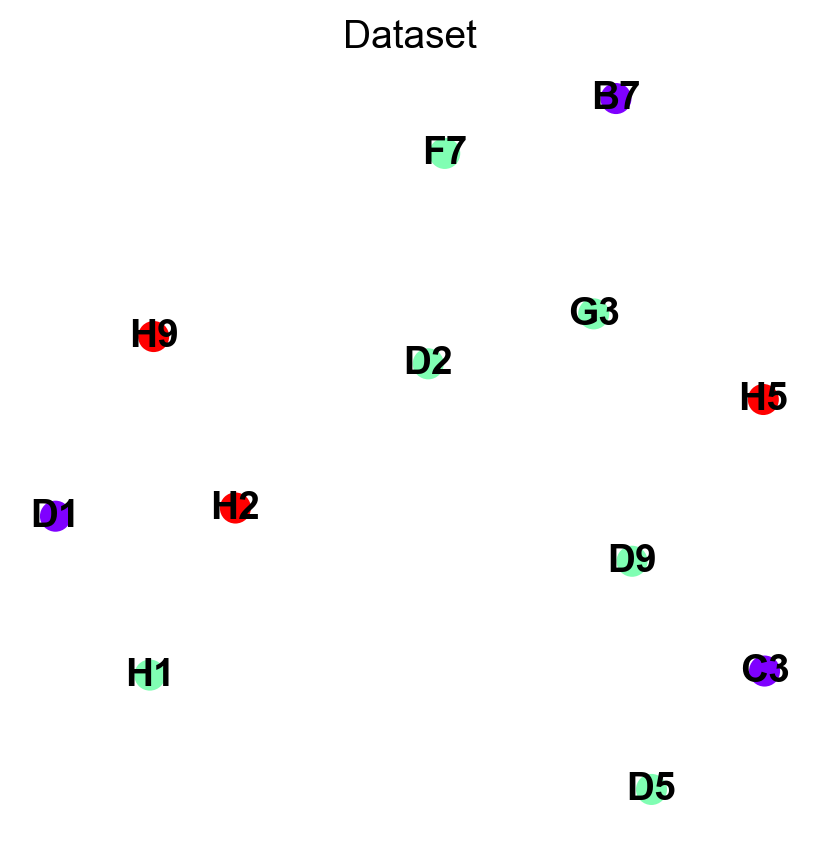

In [74]:
sc.set_figure_params(format='png')

with rc_context({'figure.figsize': (5, 5), 'figure.dpi': 100}):
    fig = sc.pl.umap(adata, color=['Dataset'], size=500,
                     add_outline=False, legend_loc='on data',
               frameon=False)

# Comparison

In [ ]:
df_cell_density = pd.DataFrame(density, index=datasets)
df_cell_density.sort_values('CD8+', inplace=True)
order = df_cell_density.index.tolist()
df_cell_density.index.name = 'ROI'
df_cell_density.reset_index(inplace=True)
df_cell_density = df_cell_density.melt(id_vars=['ROI'], var_name = 'Type', value_name='Density')
df_cell_density['Method'] = 'Cell'

In [ ]:
df_cell = pd.DataFrame(scores, index=datasets)
df_cell.index = [index[-2:] for index in df_cell.index]

In [ ]:
df_pixels = pd.DataFrame(scores_pixels, index=datasets)
df_pixels.index.name = 'ROI'
df_pixels_density = df_pixels.iloc[:,:5]
df_pixels_density.reset_index(inplace=True)
df_pixels_density = df_pixels_density.melt(id_vars=['ROI'], var_name = 'Type', value_name='Density')
df_pixels_density['Method'] = 'Pixel'

In [ ]:
df_all = pd.concat([df_cell_density, df_pixels_density])

In [ ]:
df_all.Type.unique()

In [ ]:
sns.set_style("ticks")
sns.set_context("poster")
my_pal = {'Tumor': 'm', 'CD8+':'skyblue', 'M1':'tomato' , 'M2':'springgreen', 'Stroma':'y'}
g = sns.catplot(x="ROI", y="Density", hue="Type", col="Method",
                palette=my_pal, hue_order=['Tumor', 'CD8+', 'M1',  'M2', 'Stroma'], height=8, aspect=1.5,
                kind="point", data=df_all)


In [ ]:
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x='Type', y='Density', hue='Method', data=df_all)
ax = sns.swarmplot(x='Type', y='Density', hue='Method', data=df_all, dodge=True, color=".2", size=7)
ax.set(xlabel='', ylabel='Density')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

pairs = [((t, 'Cell'), (t, 'Pixel')) for t in df_all.Type.unique()]
annotator = Annotator(ax, pairs=pairs, x='Type', y='Density', hue='Method', data=df_all)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

In [ ]:
df_cell_ = df_cell.add_prefix('Cell ')

In [ ]:
df_pixels_ = df_pixels.add_prefix('Pixel ')

In [ ]:
df_all = pd.concat([df_cell_, df_pixels_], axis=1)

In [ ]:
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm

CellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Score'

sns.set_style("ticks")
sns.set_context("talk")

ax = sns.clustermap(
    df_all.T,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.1,
    dendrogram_ratio=(0.15, 0.15),
    figsize=(7, 12),
    norm=LogNorm(),
    yticklabels=True
)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Core")
ax.ax_heatmap.set_ylabel("Score")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name)

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

In [ ]:
from matplotlib.patches import Patch


CellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Correlation'

sns.set_style("ticks")
sns.set_context("talk")

# Create a categorical palette to identify the networks
method = ['Cell', 'Pixel']
method_pal = sns.hls_palette(2, s=.45)
method_lut = dict(zip(map(str, method), method_pal))

methods = [name.split()[0] for name in df_all.columns.tolist()]
method_colors = pd.Series(methods, index=df_all.columns).map(method_lut)

ax = sns.clustermap(
    df_all.corr(),
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.1,
    dendrogram_ratio=(0.15, 0.15),
    row_colors = method_colors,
    col_colors= method_colors,
    figsize=(13, 13),
    yticklabels=True,
    xticklabels=True
)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Score")
ax.ax_heatmap.set_ylabel("Score")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name)

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    
handles = [Patch(facecolor=method_lut[name]) for name in method_lut]
plt.legend(handles, method_lut, title='Method',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [ ]:
from matplotlib.patches import Patch


ellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Correlation'


# Create a categorical palette to identify the networks
method = ['Cell', 'Pixel']
method_pal = sns.hls_palette(2, s=.45)
method_lut = dict(zip(map(str, method), method_pal))

methods = [name.split()[0] for name in df_all.T.columns.tolist()]
method_colors = pd.Series(methods, index=df_all.T.columns).map(method_lut)

ax = sns.clustermap(
    df_all.iloc[:6].T.corr(),
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.1,
    dendrogram_ratio=(0.1, 0.1),
    row_cluster=False,
    col_cluster=False,
    figsize=(10, 10),
)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Score")
ax.ax_heatmap.set_ylabel("Score")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name)

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    


In [ ]:
from matplotlib.patches import Patch


ellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Correlation'


# Create a categorical palette to identify the networks
method = ['Cell', 'Pixel']
method_pal = sns.hls_palette(2, s=.45)
method_lut = dict(zip(map(str, method), method_pal))

methods = [name.split()[0] for name in df_cell.T.columns.tolist()]
method_colors = pd.Series(methods, index=df_cell.T.columns).map(method_lut)

ax = sns.clustermap(
    df_cell.iloc[:6].T.corr(),
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.1,
    dendrogram_ratio=(0.1, 0.1),
    row_cluster=False,
    col_cluster=False,
    figsize=(10, 10),
)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Score")
ax.ax_heatmap.set_ylabel("Score")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name)

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    


In [ ]:
from matplotlib.patches import Patch


ellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Correlation'


# Create a categorical palette to identify the networks
method = ['Cell', 'Pixel']
method_pal = sns.hls_palette(2, s=.45)
method_lut = dict(zip(map(str, method), method_pal))

methods = [name.split()[0] for name in df_pixels.T.columns.tolist()]
method_colors = pd.Series(methods, index=df_pixels.T.columns).map(method_lut)

ax = sns.clustermap(
    df_pixels.iloc[:6].T.corr(),
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.1,
    dendrogram_ratio=(0.1, 0.1),
    row_cluster=False,
    col_cluster=False,
    figsize=(10, 10),
)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Score")
ax.ax_heatmap.set_ylabel("Score")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name)

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)
    


# Line plot

In [ ]:
df = pd.DataFrame(scores, index=datasets)
df

In [ ]:
df_subset = df
df_subset['Sum'] = df_subset['M1-T'] + df_subset['M2-T']
df_subset.sort_values("CD8-T", inplace=True)
df_subset = df_subset.melt(var_name="Type", value_name="Density", ignore_index=False)
df_subset.index = df_subset.index.set_names(["ROI"])
df_subset.reset_index(inplace=True)

In [ ]:
df_subset

In [ ]:
df_line = df_subset

In [ ]:
from scipy.interpolate import interp1d

x_roi = df_line[df_line.Type == "Tumor"]["ROI"]
x = np.arange(len(x_roi))
y = df_line[df_line.Type == "Tumor"]["Density"]
f = interp1d(x, y, kind="cubic")
y2 = df_line[df_line.Type == "Stroma"]["Density"]
f2 = interp1d(x, y2, kind="quadratic")
y3 = df_line[df_line.Type == "CD8+"]["Density"]
f3 = interp1d(x, y3, kind="quadratic")
y4 = df_line[df_line.Type == "M1"]["Density"]
f4 = interp1d(x, y4, kind="quadratic")
y5 = df_line[df_line.Type == "M2"]["Density"]
f5 = interp1d(x, y5, kind="quadratic")

xnew = np.linspace(0, 6, num=41, endpoint=True)
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(
    xnew,
    f(xnew),
    "magenta",
    xnew,
    f3(xnew),
    "g",
    xnew,
    f4(xnew),
    "cyan",
    xnew,
    f5(xnew),
    "orangered",
)

plt.legend(("Tumor", "CD8+", "M1", "M2"), loc="upper right", bbox_to_anchor=(1, 0))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axes.xaxis.set_ticks(x / 2, x_roi.tolist())

pos = ax.get_position()
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

In [ ]:
pairs = [
    ("B7", "F7"),
    ("C3", "G3"),
    ("D1", "H1"),
    ("D2", "H2"),
    ("D5", "H5"),
    ("D9", "H9"),
]
lung = [item[0] for item in pairs]
LN =  [item[1] for item in pairs]

In [ ]:
df_line = df_subset[df_subset.ROI.isin(lung)]

In [ ]:
from scipy.interpolate import interp1d

x_roi = df_line[df_line.Type == "Tumor"]["ROI"]
x = np.arange(len(x_roi))
y = df_line[df_line.Type == "M1-T"]["Density"]
f = interp1d(x, y, kind="cubic")
y2 = df_line[df_line.Type == "M2-T"]["Density"]
f2 = interp1d(x, y2, kind="quadratic")
y3 = df_line[df_line.Type == "CD8-T"]["Density"]
f3 = interp1d(x, y3, kind="quadratic")


xnew = np.linspace(0, 5, num=41, endpoint=True)
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(
    xnew,
    f(xnew),
    "magenta",
    xnew,
    f2(xnew),
    "g",
    xnew,
    f3(xnew),
    "cyan",
)

plt.legend(("M1-Tumor", "M2-Tumor", "CD8-Tumor"), loc="upper right", bbox_to_anchor=(1, -0.5))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axes.xaxis.set_ticks(x, x_roi.tolist())

pos = ax.get_position()
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

In [ ]:
df_line = df_subset[df_subset.ROI.isin(LN)]

x_roi = df_line[df_line.Type == "Tumor"]["ROI"]
x = np.arange(len(x_roi))
y = df_line[df_line.Type == "M1-T"]["Density"]
f = interp1d(x, y, kind="cubic")
y2 = df_line[df_line.Type == "M2-T"]["Density"]
f2 = interp1d(x, y2, kind="quadratic")
y3 = df_line[df_line.Type == "CD8-T"]["Density"]
f3 = interp1d(x, y3, kind="quadratic")


xnew = np.linspace(0, 5, num=41, endpoint=True)
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(
    xnew,
    f(xnew),
    "magenta",
    xnew,
    f2(xnew),
    "g",
    xnew,
    f3(xnew),
    "cyan",
)

plt.legend(("M1-Tumor", "M2-Tumor", "CD8-Tumor"), loc="upper right", bbox_to_anchor=(1, -0.5))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axes.xaxis.set_ticks(x, x_roi.tolist())

pos = ax.get_position()
ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

# Match tumor Lymph

In [ ]:
pairs = [('B7', 'F7'), ('C3', 'G3'), ('D1', 'H1'), ('D2', 'H2'), ('D5', 'H5'), ('D9', 'H9')]
order = list(sum(pairs, ()))

In [ ]:
df_cell_density['ROI'] = pd.Categorical(df_cell_density['ROI'], order)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
ax = sns.histplot(data=df_cell_density, x='ROI' , hue='Type', weights='Density',
             multiple='stack', shrink=0.8)
ax.set_ylabel('Density')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
ax.grid(False)

In [ ]:
datasets = list(datasets)

In [ ]:
from scipy import stats

corrs = defaultdict(list)
p_values = defaultdict(list)
for k,v in scores_all.items():
    for i in range(6):
        t_index = datasets.index(pairs[i][0])
        ln_index = datasets.index(pairs[i][1])
        
        corr, p = stats.pearsonr(v[t_index].flatten(), v[ln_index].flatten())
        corrs[k].append(corr)
        p_values[k].append(p)

In [ ]:
df = pd.DataFrame(corrs, index=pairs)

In [ ]:
fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(df.T, ax=ax, cmap='bwr')